# Deep learning programming I-A: Regression
Felix Wiewel, Institute of Signal Processing and System Theory, University of Stuttgart, 24.04.2020

## Introduction
This programming exercise is the first of a series of exercises, which are intended as a supplement to the theoretical part of the Deep Learning course offered by the ISS. The goal is to introduce you to basic tasks and applications of methods you have encountered in the lecture. After completing the exercise you should be familiar with the basic ideas and one, possibly simple, way of solving the respective task. It is worth mentioning that most of the tasks can be solved in many different, not necessarily deep learning based, ways and the solution presented here is just one of them.

## Regression

In this exercise we consider the problem of regression, where we are interested in modeling a functional dependence between different variables with, possibly noisy, observations of input-output pairs. Mathematically such a dependence can be formulated as

$\mathbf{y}=f(\mathbf{x})+\boldsymbol{\epsilon}$,

where $\mathbf{y}\in\mathbb{R}^{M}$ and $\mathbf{x}\in\mathbb{R}^{N}$ are the input and output observations, $f:\mathbb{R}^{N}\rightarrow\mathbb{R}^{M}$ is the function mapping inputs to outputs and $\boldsymbol{\epsilon}\in\mathbb{R}^{M}$ is a random vector, which models noise in our observations. Note that this assumes additive noise that only acts on the output and not on the input variable, which might not be true in all practical applications but is a reasonable approximation. For regression we are now interested in estimating the functional relationship $f$ between the inputs and outputs. This can be done in many different ways, not just with neural networks, but for this exercise we focus on approximating this relationship with a neural network $g_{\boldsymbol{\theta}}:\mathbb{R}^{N}\rightarrow\mathbb{R}^{M}$ with parameter vector $\boldsymbol{\theta}$. The task is now to choose the parameters of the neural network in a way that results in a "good" approximation of $f$ with $g_{\boldsymbol{\theta}}$.

In order to quantify how "good" our neural network can approximate $f$, we adopt a probabilistic view. For this we make the assumption that the noise $\boldsymbol{\epsilon}$ is a random vector drawn from a known dustribution, which enables us to derive a suitable cost function for training our neural network and also for quantifying a "good" approximation.

### Mathematical formulation
If we assume that the noise $\boldsymbol{\epsilon}$ is drawn from a gaussian distribution, e.g. $\boldsymbol{\epsilon}\sim\mathcal{N}(\mathbf{0},\sigma^{2}\mathbf{I})$, we can use

$\mathbf{y}=g_{\boldsymbol{\theta}}(\mathbf{x})+\boldsymbol{\epsilon}\Rightarrow \mathbf{y}-g_{\boldsymbol{\theta}}(\mathbf{x})=\boldsymbol{\epsilon}$

to derive a log likelihood. Since the probability density function (pdf) of a multivariate normal distribution is given by

$p(\mathbf{x})=\dfrac{1}{\sqrt{(2\pi)^{D}\vert\mathbf{C}\vert}}\mathrm{e}^{-\dfrac{1}{2}(\mathbf{x}-\boldsymbol{\mu})\mathbf{C}^{-1}(\mathbf{x}-\boldsymbol{\mu})^{T}}$,

we get

$\ln{p(\boldsymbol{\epsilon})}=\ln{\dfrac{1}{\sqrt{(2\pi)^{M}\sigma^{2}}}\mathrm{e}^{-\dfrac{1}{2\sigma^{2}}\Vert\boldsymbol{\epsilon}\Vert_{2}^{2}}}=-\dfrac{1}{2\sigma^{2}}\Vert\boldsymbol{\epsilon}\Vert_{2}^{2}-\dfrac{1}{2}\ln{(2\pi)^{M}\sigma^{2}}$.

Replacing $\boldsymbol{\epsilon}$ by $\mathbf{y}-g_{\boldsymbol{\theta}}(\mathbf{x})$ yields the log likelihood for one particular input-output pair:

$\mathcal{L}(\mathbf{x},\mathbf{y},\boldsymbol{\theta})=\ln {p(\mathbf{y}\vert\mathbf{x},\boldsymbol{\theta})}=-\dfrac{1}{2\sigma^{2}}\Vert\boldsymbol{\mathbf{y}-g_{\boldsymbol{\theta}}(\mathbf{x})}\Vert_{2}^{2}-\dfrac{1}{2}\ln{(2\pi)^{M}\sigma^{2}}$

This log likelihood measures how likely the input-output pair is and we can use it to train our neural network. For this we maximize the expected log likelihood over all input-output pairs under the assumption that the noise is idependent and identically distributed (i.i.d.) over all input-output pairs. This corresponds to finding the parameters $\boldsymbol{\theta}^{\star}$ of our neural network, which maximize the the expected probability for observing the corresponding input-output pairs. Mathematically the optimal parameters for our neural network are given by

$\boldsymbol{\theta}^{\star}=\arg\max_{\boldsymbol{\theta}}\mathbb{E}\left[\mathcal{L}(\mathbf{x},\mathbf{y},\boldsymbol{\theta})\right]=\arg\max_{\boldsymbol{\theta}}\mathbb{E}\left[-\Vert\boldsymbol{\mathbf{y}-g_{\boldsymbol{\theta}}(\mathbf{x})}\Vert_{2}^{2}\right]\approx\arg\min_{\boldsymbol{\theta}}\dfrac{1}{N_{D}}\sum_{i=1}^{N_{D}}\Vert\boldsymbol{\mathbf{y}_{i}-g_{\boldsymbol{\theta}}(\mathbf{x}_{i})}\Vert_{2}^{2}$,

where all terms, which are independent of $\boldsymbol{\theta}$, are ignored and the expectation operator is approximated by the mean over all $N_{D}$ input-output pairs. In other words we are maximizing the log likelihood by minimizing the mean squared error loss over all input-output pairs in our dataset, hence this approach is called Maximum Likelihood (ML) estimation. For solving this optimization problem and obtaining the optimal network parameters, stochastic gradient descent (SGD) or one of it's many variants is typically used.

It is worth noting, that choosing different distributions for the noise $\boldsymbol{\epsilon}$ leads to different log likelihoods and therefore different cost functions for training the neural network. Another commonly used distribution for modelling the noise in regression tasks is the laplace distribution. Deriving the log likelihood and the corresponding costfunction leads to the mean absolute error, which is given by the $l_{1}$-norm of the difference between observations predictions of the neural network. This cost function is considered more robust against outliers since these have less influence on the averall loss compared to the mean squared error.

###  Implementation

In the following we consider a simple regression task, implement a neural network and train it based on the mathematical fomrulation above. For this we first need to create a set of input-output pairs, which then needs to be partitioned into a training, validation and test set. We also define some constants to be used for partitioning the data and the hyperparameters for our neural network.

But before we can start, we need to import the necessary packages tensorflow, numpy and matplotlib.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Next we define our constants and set the random seeds of tensorflow and numpy in order to get reproducable results.

In [2]:
N_train_samples = 600
N_validation_samples = 100
N_test_samples = 100
N_samples = N_train_samples + N_validation_samples + N_test_samples
noise_sig = 0.1
N_epochs = 150
batch_size = 8
learning_rate = 0.01

tf.random.set_seed(0)
np.random.seed(0)

We create $600$ training samples, $100$ validation samples to optimize our hyperparameters and $100$ test samples, which are used to check if our model can generalize to unseen data. Furthermore we set the level of noise added to the observations. For training the model we plan to train it for $150$ epochs with a batch size of $8$ and a learning rate of $0.01$. Next we create the actual input-output pairs $\mathbf{x},\mathbf{y}$ for which we want to learn the regression model and plot them. In this simple example we choose scalar inputs as well as output but in general $\mathbf{x}$ and $\mathbf{y}$ can be vectors.

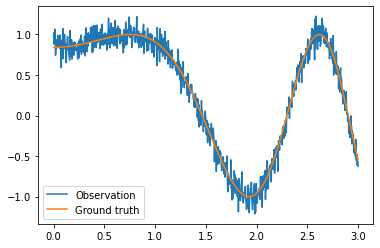

In [3]:
x = np.linspace(0.0, 3.0, N_samples, dtype=np.float32)
y = np.expand_dims(np.sin(1.0+x*x) + noise_sig*np.random.randn(N_samples).astype(np.float32), axis=-1)
y_true = np.sin(1.0+x*x)

plt.plot(x, y)
plt.plot(x, y_true)
plt.legend(["Observation", "Ground truth"])
plt.show()

With the input-output pairs created, your first task is now to partition the data in the training, validation and test sets. Keep in mind that we have created the data in a structured way, i.e. the input-output pairs are ordered. This means you need to shuffle the data before partitioning it.

In [4]:
shuffle_idx = np.arange(0, N_samples)
np.random.shuffle(shuffle_idx)
x_shuffled = x[shuffle_idx]
y_shuffled = y[shuffle_idx]
x_train = x_shuffled[0:N_train_samples]
y_train = y_shuffled[0:N_train_samples]
x_validation = x_shuffled[N_train_samples:N_train_samples+N_validation_samples]
y_validation = y_shuffled[N_train_samples:N_train_samples+N_validation_samples]
x_test = x_shuffled[N_train_samples+N_validation_samples:]
y_test = y_shuffled[N_train_samples+N_validation_samples:]

In order to feed the data to our model, we will use the Dataset class provided by Tensorflow. This class is simple to use and provides all the functionality we need for shuffling, batching and feeding the data to our model. It is also tightly integrated into the Tensorflow framework, which makes it very performant. Performance is not an aspect we need to worry about in this exercise, but it is important in more demanding applications.

In this exercise we instantiate a separate Dataset object for the training, validation and test data sets, where we shuffle and repeat just the training data set. Shuffling the validation and test data sets is not necessary, since we only evaluate the loss on those data sets and do not perform SGD on it. Please fill in the missing part of the code.

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(N_train_samples).batch(batch_size).repeat()
validation_ds = tf.data.Dataset.from_tensor_slices((x_validation, y_validation))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In this exercise we will create a a simple neural network with two hidden layers containing $10$ neurons. For creating a model and keeping track of its weights a class called MyModel is used. When initializing an instance of this class the necessary variables are created and stored in a list called "trainable_variables". This makes it easy to get all trainable variables of the model. We also override the \__call__ method of this class in order to implement the forward pass of the neural network. This method should accept the inputs to the neural network and should return the result of the forward pass as an output. Please fill in the missing part of the code and select suitable activation functions for the different layers.

In [6]:
class MyModel(object):
    def __init__(self):
        # Create model variables
        self.W0 = tf.Variable(tf.random.normal([1, 10]), name="W0")
        self.b0 = tf.Variable(tf.zeros(10), name="b0")
        self.W1 = tf.Variable(tf.random.normal([10, 10]), name="W1")
        self.b1 = tf.Variable(tf.zeros(10), name="b1")
        self.W2 = tf.Variable(tf.random.normal([10, 1]), name="W2")
        self.b2 = tf.Variable(tf.zeros(1), name="b2")
        self.trainable_variables = [self.W0, self.b0, self.W1, self.b1, self.W2, self.b2]

    def __call__(self, inputs):
        # Compute forward pass
        output = tf.reshape(inputs, [-1, 1])
        output = tf.nn.tanh(tf.add(tf.matmul(output, self.W0), self.b0))
        output = tf.nn.tanh(tf.add(tf.matmul(output, self.W1), self.b1))
        output = tf.add(tf.matmul(output, self.W2), self.b2)
        return output

Now after the model class is defined we can instantiate a MyModel object by running

In [7]:
mdl = MyModel()

We can now use the model to make predictions by calling it. In the following we predict on the inputs and plot the result.

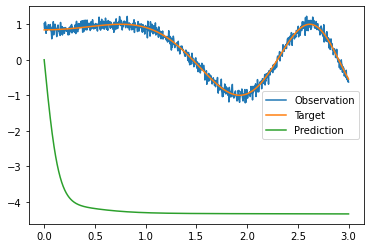

In [8]:
y_pred = mdl(x)
plt.plot(x, y)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.legend(["Observation", "Target", "Prediction"])
plt.show()

Since we have initialized the variables of the neural network randomly, it's prediction is also random. In order to fit the model we need to minimize the expected mean squared error over all input-ouput pairs in our training data set. For this we need to create a function, that performs a training step when provided with the model, an optimizer and a batch of input-ouput pairs.

In [9]:
def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        y_pred = model(x)
        loss_val = tf.reduce_mean(tf.square(y-y_pred))
    grads = tape.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_val

This function uses the GradientTape to record the operations for which gradients have to be calculated. In our case this is the forward pass through our model and the computation of the loss function. After these operations are recoded we can get their gradients and apply these through the use of an optimizer. Finally we return the loss value in order to print it.

With the training step function defined we now need to choose a suitable optimizer. Tensorflow offers a wide variety of optimizers but in this exercise we will use the RMSprop optimizer.

In [10]:
opt = tf.optimizers.RMSprop(learning_rate)

We now have everything we need to start training the model. For this we repeatedly sample a batch of input-output pairs from our training data set and use the train_step function to minimize the loss function over this batch. We repeat this until we have iterated over the complete training data set once. After this we compute the loss on the validation data set, print it and repeat with another epoch until we have reached $N\_epochs$ epochs.

In [11]:
epoch = 0
train_iters = 0
train_loss = 0.0
for x_t, y_t in train_ds:
    train_loss += train_step(mdl, opt, x_t, y_t)
    train_iters += 1
    if (train_iters >= int(N_train_samples/batch_size)):
        for x_v, y_v in validation_ds:
            y_pred = mdl(x_v)
            validation_loss = tf.reduce_mean(tf.square(y_v-y_pred))
        print("Epoch: {} Train loss: {:.5} Validation loss: {:.5}".format(epoch, train_loss/train_iters, validation_loss))
        train_iters = 0
        train_loss = 0.0
        epoch += 1
    if (epoch == N_epochs):
        break

Epoch: 0 Train loss: 2.2108 Validation loss: 0.00047865
Epoch: 1 Train loss: 0.2822 Validation loss: 0.10151
Epoch: 2 Train loss: 0.22032 Validation loss: 0.073666
Epoch: 3 Train loss: 0.18114 Validation loss: 0.095459
Epoch: 4 Train loss: 0.14561 Validation loss: 0.0049092
Epoch: 5 Train loss: 0.11869 Validation loss: 0.00046799
Epoch: 6 Train loss: 0.10799 Validation loss: 0.0036279
Epoch: 7 Train loss: 0.10069 Validation loss: 6.7387e-06
Epoch: 8 Train loss: 0.0945 Validation loss: 0.00066844
Epoch: 9 Train loss: 0.087253 Validation loss: 0.057752
Epoch: 10 Train loss: 0.088943 Validation loss: 0.050971
Epoch: 11 Train loss: 0.083987 Validation loss: 0.0029764
Epoch: 12 Train loss: 0.079775 Validation loss: 0.045645
Epoch: 13 Train loss: 0.072237 Validation loss: 0.018482
Epoch: 14 Train loss: 0.060768 Validation loss: 0.0060692
Epoch: 15 Train loss: 0.059487 Validation loss: 2.2146e-05
Epoch: 16 Train loss: 0.052268 Validation loss: 0.0071122
Epoch: 17 Train loss: 0.056074 Validati

Epoch: 141 Train loss: 0.022617 Validation loss: 0.0069044
Epoch: 142 Train loss: 0.022239 Validation loss: 0.013103
Epoch: 143 Train loss: 0.020525 Validation loss: 4.3066e-05
Epoch: 144 Train loss: 0.023442 Validation loss: 0.0037217
Epoch: 145 Train loss: 0.021785 Validation loss: 0.0013598
Epoch: 146 Train loss: 0.02052 Validation loss: 0.00017626
Epoch: 147 Train loss: 0.02249 Validation loss: 0.00029693
Epoch: 148 Train loss: 0.019637 Validation loss: 0.0033302
Epoch: 149 Train loss: 0.022183 Validation loss: 0.0011127


After completion of the training process we use the test data set to test the models generalization to unseen data.

In [12]:
for x_t, y_t in test_ds:
    y_pred = mdl(x_t)
    test_loss = tf.reduce_mean(tf.square(y_t-y_pred))
print("Test loss: {:.5}".format(test_loss))

Test loss: 0.016941


After we have verified that our model achieves a similar loss on the test as on the validation and training data set, we can conclude that our model is not overfitting or underfitting and generalizes to unseen data. We can now predict on the inputs again and plot the results.

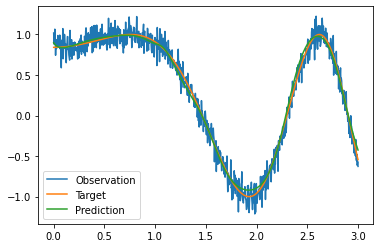

In [13]:
y_pred = mdl(x)
plt.plot(x, y)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.legend(["Observation", "Target", "Prediction"])
plt.show()

Now our model has learned to approximate the function mapping from the input to the output. The capability of neural networks to learn from input-ouput pairs alone and approximate an arbitrary function, see universal approximation theorem, can be very useful if the mapping between the input and output is too complex to be captured with model based approaches. But learning from input-ouput pairs alone implies that the model will only be able to make accurate predictions over input ranges it has seen during training. In order to demonstrate this we will predict on an interval that exeeds the $\left[0,3\right]$ interval the model was trained on, i.e. we will predict on the interval $\left[-2,5\right]$.

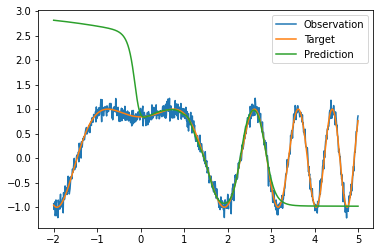

In [14]:
x_generalize = np.linspace(-2.0, 5.0, N_samples, dtype=np.float32)
y_generalize = np.sin(1.0+x_generalize*x_generalize) + noise_sig*np.random.randn(N_samples).astype(np.float32)
y_truey_generalize = np.sin(1.0+x_generalize*x_generalize)
y_pred = mdl(x_generalize)
plt.plot(x_generalize, y_generalize)
plt.plot(x_generalize, y_truey_generalize)
plt.plot(x_generalize, y_pred.numpy())
plt.legend(["Observation", "Target", "Prediction"])
plt.show()

As expected, the model is able to make farely accurate predictions on the interval it was trained on but makes unreliable predictions outside this interval.

### Regularization
In this section we will explore the concept of regularization. As there is no theorem that can be used to determine the required size and structure of a neural network given a certain task, one has to find a suitable neural architecture by trial and error. This can result in choosing a architecture with a capacity that is higher than required for solving the given task and hence overfitting might occur. A common way to prevent large neural networks networks from overfitting is to employ some sort of regularization, e.g. weight norm penalty, dropout, early stopping and data augmentation. In this section we will focus on weight norm penalty as a regularization and derive a probabilistic interpretation for some of those.

We start by restating the conditional probability of the output $\mathbf{y}$ given the input $\mathbf{x}$ and the networks parameters $\boldsymbol{\theta}$

$p(\mathbf{y}\vert\mathbf{x},\boldsymbol{\theta})=\dfrac{1}{\sqrt{(2\pi)^{M}\sigma^{2}}}\mathrm{e}^{-\dfrac{1}{2\sigma^{2}}\Vert\boldsymbol{\mathbf{y}-g_{\boldsymbol{\theta}}(\mathbf{x})}\Vert_{2}^{2}}$,

which we used to derive the log likelihood. If we have some prior knowledge about the parameters of the neural network, which is given by a pdf $p(\boldsymbol{\theta})$ over the weights, we can use Bayes theorem to derive a posterior distribution

$p(\boldsymbol{\theta}\vert\mathbf{x},\mathbf{y})=\dfrac{p(\boldsymbol{\theta},\mathbf{y}\vert\mathbf{x})}{p(\mathbf{y})}=\dfrac{p(\mathbf{y}\vert\mathbf{x},\boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathbf{y})}$

where $p(\boldsymbol{\theta})$ is the  prior over the networks parameters. Similar to the derivation at the beginning of the exercise, we can use this posterior distribution to derive a cost function for training the neural network. In this case, however, we are not maximizing the log likelihood but the posterior distribution over the weights, hence this approach is called Maximum A Posteori (MAP) estimation of the parameters. Mathematically we can formulate this as

$\boldsymbol{\theta}^{\star}=\arg\max_{\boldsymbol{\theta}}\mathbb{E}\left[p(\boldsymbol{\theta}\vert\mathbf{x},\mathbf{y})\right]=\arg\max_{\boldsymbol{\theta}}\mathbb{E}\left[\ln{p(\boldsymbol{\theta}\vert\mathbf{x},\mathbf{y})}\right]=\arg\max_{\boldsymbol{\theta}}\ln{p(\boldsymbol{\theta})}+\mathbb{E}\left[\ln{p(\mathbf{y}\vert\mathbf{x},\boldsymbol{\theta})}\right]$,

where we used the fact that applying a strictly increasing function, e.g. $\ln{}$, does not change the position of the maximum of a cost function, ignored $p(\mathbf{y})$, since it is independent of the network parameters and dropped the expectation operator for $\ln{p(\boldsymbol{\theta})}$, since it is not depending on the random variable $\mathbf{x}$. Comparing the MAP estimate of the parameters with the ML estimate we derived above, shows that the only difference is the addition of $\ln{p(\boldsymbol{\theta})}$. This term is the regularization, i.e. the weight norm penalty. Depending on the distribution over $\boldsymbol{\theta}$ it can have different forms. If we choose a standard normal distribution, i.e. $\boldsymbol{\theta\sim\mathcal{N}(\mathbf{0},\mathbf{I})}$,  we get

$\boldsymbol{\theta}^{\star}=\arg\min_{\boldsymbol{\theta}}\lambda\Vert\boldsymbol{\theta}\Vert_{2}^{2}+\dfrac{1}{N_{D}}\sum_{i=1}^{N_{D}}\Vert\boldsymbol{\mathbf{y}_{i}-g_{\boldsymbol{\theta}}(\mathbf{x}_{i})}\Vert_{2}^{2}$,

where we have made the same simplifications as for the ML estimation and also introduced the parameter $\lambda=\sigma^{2}$, which is used to control the strength of the regularization. This form of regularization is commonly known as $l_{2}$-norm or weight decay regularization. Choosing a prior where the weights follow an i.i.d laplacian distribution, i.e. $p(\boldsymbol{\theta})=\prod_{j}\dfrac{1}{2}\mathrm{e}^{\vert\theta_{j}\vert}$, leads to

$\boldsymbol{\theta}^{\star}=\arg\min_{\boldsymbol{\theta}}\lambda\Vert\boldsymbol{\theta}\Vert_{1}+\dfrac{1}{N_{D}}\sum_{i=1}^{N_{D}}\Vert\boldsymbol{\mathbf{y}_{i}-g_{\boldsymbol{\theta}}(\mathbf{x}_{i})}\Vert_{2}^{2}$,

where the strength of the regularization is again controlled by $\lambda=\sigma^{2}$. This type of regularization is known as  $l_{1}$-norm and it has the property to induce sparsity in the parameters of the network.

With this theoretical background on regularization we can now implement it and observe it's effects on the regression problem covered in this exercise. For this we will define a model with a high capacity and train it for a extended time to provoke overfitting. For this, we will increase the number of hidden neurons in both hidden layers to $100$ and $50$.

In [15]:
class MyBigModel(object):
    def __init__(self):
        # Create model variables
        self.W0 = tf.Variable(tf.random.normal([1, 100]), name="W0")
        self.b0 = tf.Variable(tf.zeros(100), name="b0")
        self.W1 = tf.Variable(tf.random.normal([100, 50]), name="W1")
        self.b1 = tf.Variable(tf.zeros(50), name="b1")
        self.W2 = tf.Variable(tf.random.normal([50, 1]), name="W2")
        self.b2 = tf.Variable(tf.zeros(1), name="b2")
        self.trainable_variables = [self.W0, self.b0, self.W1, self.b1, self.W2, self.b2]

    def __call__(self, inputs):
        # Compute forward pass
        output = tf.reshape(inputs, [-1, 1])
        output = tf.nn.tanh(tf.add(tf.matmul(output, self.W0), self.b0))
        output = tf.nn.tanh(tf.add(tf.matmul(output, self.W1), self.b1))
        output = tf.add(tf.matmul(output, self.W2), self.b2)
        return output

After creating one instance of this class we can again train it on our data set. We will also create a new optimizer for training this bigger model, since some optimizers adapt the learning rates for individual parameters during a training process and we do not want to train our bigger model with learning rates adopted from an earlier training run.

In [16]:
big_mdl = MyBigModel()
big_opt = tf.optimizers.SGD(learning_rate)

Now we are ready to train this bigger model using the same training step and training loop. In order to provoke overfitting we also reduce the number of samples in the training data set a lot, increase the batch size and train for a more epochs.

In [17]:
N_train_samples_overfit = 30
N_epochs = 1000
batch_size = 30

sel_idx = np.arange(0, N_train_samples)
sel_idx = np.random.choice(sel_idx, N_train_samples_overfit)
x_train_overfit = x_train[sel_idx]
y_train_overfit = y_train[sel_idx]

train_overfit_ds = tf.data.Dataset.from_tensor_slices((x_train_overfit, y_train_overfit)).shuffle(N_train_samples_overfit).batch(batch_size).repeat()

epoch = 0
train_iters = 0
train_loss = 0.0
for x_t, y_t in train_overfit_ds:
    train_loss += train_step(big_mdl, big_opt, x_t, y_t)
    train_iters += 1
    if (train_iters >= int(N_train_samples/batch_size)):
        for x_v, y_v in validation_ds:
            y_pred = big_mdl(x_v)
            validation_loss = tf.reduce_mean(tf.square(y_v-y_pred))
        print("Epoch: {} Train loss: {:.5} Validation loss: {:.5}".format(epoch, train_loss/train_iters, validation_loss))
        train_iters = 0
        train_loss = 0.0
        epoch += 1
    if (epoch == N_epochs):
        break

Epoch: 0 Train loss: 5.6913 Validation loss: 0.055895
Epoch: 1 Train loss: 0.4463 Validation loss: 0.077307
Epoch: 2 Train loss: 0.40666 Validation loss: 0.0721
Epoch: 3 Train loss: 0.36342 Validation loss: 0.044384
Epoch: 4 Train loss: 0.32765 Validation loss: 0.027146
Epoch: 5 Train loss: 0.30377 Validation loss: 0.013628
Epoch: 6 Train loss: 0.29629 Validation loss: 0.0094615
Epoch: 7 Train loss: 0.29062 Validation loss: 0.010562
Epoch: 8 Train loss: 0.27358 Validation loss: 0.022572
Epoch: 9 Train loss: 0.20632 Validation loss: 0.023897
Epoch: 10 Train loss: 0.15796 Validation loss: 0.019674
Epoch: 11 Train loss: 0.12164 Validation loss: 0.017109
Epoch: 12 Train loss: 0.23487 Validation loss: 0.00022773
Epoch: 13 Train loss: 0.20412 Validation loss: 0.0011671
Epoch: 14 Train loss: 0.19152 Validation loss: 0.0019508
Epoch: 15 Train loss: 0.17945 Validation loss: 0.0027763
Epoch: 16 Train loss: 0.16571 Validation loss: 0.0038098
Epoch: 17 Train loss: 0.1495 Validation loss: 0.0052088

Epoch: 144 Train loss: 0.017072 Validation loss: 0.02062
Epoch: 145 Train loss: 0.017046 Validation loss: 0.02062
Epoch: 146 Train loss: 0.017018 Validation loss: 0.02062
Epoch: 147 Train loss: 0.016989 Validation loss: 0.020619
Epoch: 148 Train loss: 0.016959 Validation loss: 0.020617
Epoch: 149 Train loss: 0.016928 Validation loss: 0.020614
Epoch: 150 Train loss: 0.016895 Validation loss: 0.020611
Epoch: 151 Train loss: 0.016859 Validation loss: 0.020606
Epoch: 152 Train loss: 0.016822 Validation loss: 0.0206
Epoch: 153 Train loss: 0.016781 Validation loss: 0.020592
Epoch: 154 Train loss: 0.016738 Validation loss: 0.020584
Epoch: 155 Train loss: 0.01669 Validation loss: 0.020571
Epoch: 156 Train loss: 0.016639 Validation loss: 0.020557
Epoch: 157 Train loss: 0.016582 Validation loss: 0.020539
Epoch: 158 Train loss: 0.01652 Validation loss: 0.020516
Epoch: 159 Train loss: 0.01645 Validation loss: 0.020487
Epoch: 160 Train loss: 0.016372 Validation loss: 0.020452
Epoch: 161 Train loss:

Epoch: 285 Train loss: 0.0074112 Validation loss: 0.018299
Epoch: 286 Train loss: 0.007393 Validation loss: 0.018273
Epoch: 287 Train loss: 0.007375 Validation loss: 0.018248
Epoch: 288 Train loss: 0.0073572 Validation loss: 0.018223
Epoch: 289 Train loss: 0.0073397 Validation loss: 0.018198
Epoch: 290 Train loss: 0.0073225 Validation loss: 0.018173
Epoch: 291 Train loss: 0.0073056 Validation loss: 0.018148
Epoch: 292 Train loss: 0.0072889 Validation loss: 0.018124
Epoch: 293 Train loss: 0.0072724 Validation loss: 0.018099
Epoch: 294 Train loss: 0.0072561 Validation loss: 0.018075
Epoch: 295 Train loss: 0.0072401 Validation loss: 0.01805
Epoch: 296 Train loss: 0.0072244 Validation loss: 0.018026
Epoch: 297 Train loss: 0.0072088 Validation loss: 0.018002
Epoch: 298 Train loss: 0.0071935 Validation loss: 0.017978
Epoch: 299 Train loss: 0.0071784 Validation loss: 0.017954
Epoch: 300 Train loss: 0.0071636 Validation loss: 0.01793
Epoch: 301 Train loss: 0.0071489 Validation loss: 0.017906
E

Epoch: 426 Train loss: 0.0077211 Validation loss: 0.018283
Epoch: 427 Train loss: 0.0076776 Validation loss: 0.018221
Epoch: 428 Train loss: 0.0076302 Validation loss: 0.018157
Epoch: 429 Train loss: 0.0075811 Validation loss: 0.018091
Epoch: 430 Train loss: 0.0075322 Validation loss: 0.018026
Epoch: 431 Train loss: 0.0074849 Validation loss: 0.017964
Epoch: 432 Train loss: 0.0074404 Validation loss: 0.017904
Epoch: 433 Train loss: 0.0073994 Validation loss: 0.017847
Epoch: 434 Train loss: 0.0073621 Validation loss: 0.017796
Epoch: 435 Train loss: 0.0073293 Validation loss: 0.017749
Epoch: 436 Train loss: 0.0073009 Validation loss: 0.017707
Epoch: 437 Train loss: 0.0072771 Validation loss: 0.017671
Epoch: 438 Train loss: 0.0072581 Validation loss: 0.017639
Epoch: 439 Train loss: 0.0072431 Validation loss: 0.017612
Epoch: 440 Train loss: 0.0072323 Validation loss: 0.017591
Epoch: 441 Train loss: 0.007225 Validation loss: 0.017573
Epoch: 442 Train loss: 0.0072216 Validation loss: 0.01755

Epoch: 567 Train loss: 0.0069157 Validation loss: 0.015933
Epoch: 568 Train loss: 0.0069129 Validation loss: 0.015922
Epoch: 569 Train loss: 0.00691 Validation loss: 0.015911
Epoch: 570 Train loss: 0.0069071 Validation loss: 0.0159
Epoch: 571 Train loss: 0.0069042 Validation loss: 0.015888
Epoch: 572 Train loss: 0.0069013 Validation loss: 0.015877
Epoch: 573 Train loss: 0.0068985 Validation loss: 0.015866
Epoch: 574 Train loss: 0.0068957 Validation loss: 0.015855
Epoch: 575 Train loss: 0.006893 Validation loss: 0.015844
Epoch: 576 Train loss: 0.0068904 Validation loss: 0.015833
Epoch: 577 Train loss: 0.0068878 Validation loss: 0.015823
Epoch: 578 Train loss: 0.0068851 Validation loss: 0.015812
Epoch: 579 Train loss: 0.0068827 Validation loss: 0.015801
Epoch: 580 Train loss: 0.0068799 Validation loss: 0.015791
Epoch: 581 Train loss: 0.0068772 Validation loss: 0.01578
Epoch: 582 Train loss: 0.0068746 Validation loss: 0.01577
Epoch: 583 Train loss: 0.0068719 Validation loss: 0.015759
Epoc

Epoch: 708 Train loss: 0.0065625 Validation loss: 0.014712
Epoch: 709 Train loss: 0.0065603 Validation loss: 0.014706
Epoch: 710 Train loss: 0.0065579 Validation loss: 0.0147
Epoch: 711 Train loss: 0.0065556 Validation loss: 0.014694
Epoch: 712 Train loss: 0.0065535 Validation loss: 0.014687
Epoch: 713 Train loss: 0.0065515 Validation loss: 0.014681
Epoch: 714 Train loss: 0.0065494 Validation loss: 0.014675
Epoch: 715 Train loss: 0.0065474 Validation loss: 0.014669
Epoch: 716 Train loss: 0.0065452 Validation loss: 0.014663
Epoch: 717 Train loss: 0.0065432 Validation loss: 0.014657
Epoch: 718 Train loss: 0.0065411 Validation loss: 0.014651
Epoch: 719 Train loss: 0.0065389 Validation loss: 0.014645
Epoch: 720 Train loss: 0.0065366 Validation loss: 0.014639
Epoch: 721 Train loss: 0.0065343 Validation loss: 0.014633
Epoch: 722 Train loss: 0.006532 Validation loss: 0.014627
Epoch: 723 Train loss: 0.0065298 Validation loss: 0.014621
Epoch: 724 Train loss: 0.006528 Validation loss: 0.014615
E

Epoch: 849 Train loss: 0.0062943 Validation loss: 0.014063
Epoch: 850 Train loss: 0.0062928 Validation loss: 0.01406
Epoch: 851 Train loss: 0.0062912 Validation loss: 0.014057
Epoch: 852 Train loss: 0.0062897 Validation loss: 0.014054
Epoch: 853 Train loss: 0.0062882 Validation loss: 0.014051
Epoch: 854 Train loss: 0.0062866 Validation loss: 0.014048
Epoch: 855 Train loss: 0.0062852 Validation loss: 0.014045
Epoch: 856 Train loss: 0.0062838 Validation loss: 0.014043
Epoch: 857 Train loss: 0.0062822 Validation loss: 0.014039
Epoch: 858 Train loss: 0.0062804 Validation loss: 0.014036
Epoch: 859 Train loss: 0.0062784 Validation loss: 0.014032
Epoch: 860 Train loss: 0.0062765 Validation loss: 0.014029
Epoch: 861 Train loss: 0.0062746 Validation loss: 0.014026
Epoch: 862 Train loss: 0.006273 Validation loss: 0.014023
Epoch: 863 Train loss: 0.0062713 Validation loss: 0.01402
Epoch: 864 Train loss: 0.0062697 Validation loss: 0.014017
Epoch: 865 Train loss: 0.0062679 Validation loss: 0.014013


Epoch: 990 Train loss: 0.0060879 Validation loss: 0.013739
Epoch: 991 Train loss: 0.0060867 Validation loss: 0.013737
Epoch: 992 Train loss: 0.0060858 Validation loss: 0.013736
Epoch: 993 Train loss: 0.0060848 Validation loss: 0.013736
Epoch: 994 Train loss: 0.0060841 Validation loss: 0.013735
Epoch: 995 Train loss: 0.0060832 Validation loss: 0.013733
Epoch: 996 Train loss: 0.0060822 Validation loss: 0.013732
Epoch: 997 Train loss: 0.006081 Validation loss: 0.013731
Epoch: 998 Train loss: 0.0060797 Validation loss: 0.013729
Epoch: 999 Train loss: 0.0060783 Validation loss: 0.013727


Predicting with this model shows overfitting. For recognizing overfitting a comparison of the validation and training loss is very useful. If the training loss decreases during training while the validation loss consistently increases, the model you are training is probably overfitting. Plotting the models prediction and the target also shows that there is a significant discrepancy between the target and the prediction of the model.

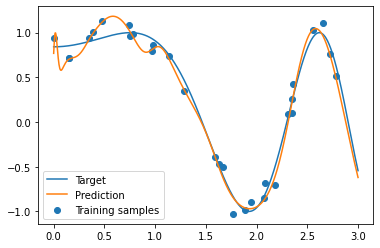

In [18]:
y_pred = big_mdl(x)
plt.scatter(x_train_overfit, y_train_overfit)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.legend(["Target", "Prediction", "Training samples"])
plt.show()

In order to implement a regularization we need to modify the loss function. Since the loss function in this exercise is computed during the training step, we define a new training step with a regularization.

In [19]:
def regularized_train_step(model, optimizer, x, y, lmbd):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        y_pred = model(x)
        loss_val = tf.reduce_mean(tf.square(y-y_pred))
        regul_val = tf.reduce_sum([tf.reduce_sum(tf.square(w)) for w in model.trainable_variables])
        total_loss = tf.add(loss_val, lmbd*regul_val)
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_val

We can now set the strength of the regularization and retrain the big model with a regularization. We create another instance of the big model in order to compare the big model with and without regularization.

In [20]:
lmbd = 0.005

big_reg_mdl = MyBigModel()
big_opt = tf.optimizers.SGD(learning_rate)

epoch = 0
train_iters = 0
train_loss = 0.0
for x_t, y_t in train_overfit_ds:
    train_loss += regularized_train_step(big_reg_mdl, big_opt, x_t, y_t, lmbd)
    train_iters += 1
    if (train_iters >= int(N_train_samples/batch_size)):
        for x_v, y_v in validation_ds:
            y_pred = big_reg_mdl(x_v)
            validation_loss = tf.reduce_mean(tf.square(y_v-y_pred))
        print("Epoch: {} Train loss: {:.5} Validation loss: {:.5}".format(epoch, train_loss/train_iters, validation_loss))
        train_iters = 0
        train_loss = 0.0
        train_reg = 0.0
        epoch += 1
    if (epoch == N_epochs):
        break

Epoch: 0 Train loss: 3.6055 Validation loss: 0.039258
Epoch: 1 Train loss: 0.41759 Validation loss: 0.0080976
Epoch: 2 Train loss: 0.36502 Validation loss: 0.040421
Epoch: 3 Train loss: 0.32119 Validation loss: 0.023333
Epoch: 4 Train loss: 0.30452 Validation loss: 0.01747
Epoch: 5 Train loss: 0.29173 Validation loss: 0.016035
Epoch: 6 Train loss: 0.27988 Validation loss: 0.015641
Epoch: 7 Train loss: 0.26768 Validation loss: 0.015709
Epoch: 8 Train loss: 0.25419 Validation loss: 0.016013
Epoch: 9 Train loss: 0.23873 Validation loss: 0.016283
Epoch: 10 Train loss: 0.22156 Validation loss: 0.016054
Epoch: 11 Train loss: 0.20421 Validation loss: 0.01532
Epoch: 12 Train loss: 0.18759 Validation loss: 0.014524
Epoch: 13 Train loss: 0.17172 Validation loss: 0.013811
Epoch: 14 Train loss: 0.15666 Validation loss: 0.013143
Epoch: 15 Train loss: 0.14253 Validation loss: 0.012481
Epoch: 16 Train loss: 0.12947 Validation loss: 0.011807
Epoch: 17 Train loss: 0.11755 Validation loss: 0.011121
Epoc

Epoch: 142 Train loss: 0.022756 Validation loss: 0.0013071
Epoch: 143 Train loss: 0.022755 Validation loss: 0.0013302
Epoch: 144 Train loss: 0.022754 Validation loss: 0.0013528
Epoch: 145 Train loss: 0.022754 Validation loss: 0.0013753
Epoch: 146 Train loss: 0.022754 Validation loss: 0.0013977
Epoch: 147 Train loss: 0.022755 Validation loss: 0.0014195
Epoch: 148 Train loss: 0.022756 Validation loss: 0.0014413
Epoch: 149 Train loss: 0.022758 Validation loss: 0.0014627
Epoch: 150 Train loss: 0.02276 Validation loss: 0.0014839
Epoch: 151 Train loss: 0.022762 Validation loss: 0.0015048
Epoch: 152 Train loss: 0.022765 Validation loss: 0.0015255
Epoch: 153 Train loss: 0.022768 Validation loss: 0.0015457
Epoch: 154 Train loss: 0.022772 Validation loss: 0.0015656
Epoch: 155 Train loss: 0.022776 Validation loss: 0.0015852
Epoch: 156 Train loss: 0.02278 Validation loss: 0.0016044
Epoch: 157 Train loss: 0.022785 Validation loss: 0.0016233
Epoch: 158 Train loss: 0.02279 Validation loss: 0.0016417


Epoch: 282 Train loss: 0.025198 Validation loss: 0.00084447
Epoch: 283 Train loss: 0.025227 Validation loss: 0.00082643
Epoch: 284 Train loss: 0.025257 Validation loss: 0.00080851
Epoch: 285 Train loss: 0.025287 Validation loss: 0.00079066
Epoch: 286 Train loss: 0.025317 Validation loss: 0.00077289
Epoch: 287 Train loss: 0.025347 Validation loss: 0.00075531
Epoch: 288 Train loss: 0.025377 Validation loss: 0.00073779
Epoch: 289 Train loss: 0.025407 Validation loss: 0.00072045
Epoch: 290 Train loss: 0.025438 Validation loss: 0.00070318
Epoch: 291 Train loss: 0.025468 Validation loss: 0.00068605
Epoch: 292 Train loss: 0.025499 Validation loss: 0.00066908
Epoch: 293 Train loss: 0.025529 Validation loss: 0.00065225
Epoch: 294 Train loss: 0.02556 Validation loss: 0.00063552
Epoch: 295 Train loss: 0.025591 Validation loss: 0.00061904
Epoch: 296 Train loss: 0.025622 Validation loss: 0.0006026
Epoch: 297 Train loss: 0.025653 Validation loss: 0.00058639
Epoch: 298 Train loss: 0.025684 Validation

Epoch: 420 Train loss: 0.029781 Validation loss: 0.00034771
Epoch: 421 Train loss: 0.029814 Validation loss: 0.00036085
Epoch: 422 Train loss: 0.029846 Validation loss: 0.00037423
Epoch: 423 Train loss: 0.029878 Validation loss: 0.00038787
Epoch: 424 Train loss: 0.02991 Validation loss: 0.00040174
Epoch: 425 Train loss: 0.029942 Validation loss: 0.00041589
Epoch: 426 Train loss: 0.029974 Validation loss: 0.00043027
Epoch: 427 Train loss: 0.030006 Validation loss: 0.00044492
Epoch: 428 Train loss: 0.030037 Validation loss: 0.0004598
Epoch: 429 Train loss: 0.030069 Validation loss: 0.00047493
Epoch: 430 Train loss: 0.030101 Validation loss: 0.00049032
Epoch: 431 Train loss: 0.030133 Validation loss: 0.00050594
Epoch: 432 Train loss: 0.030164 Validation loss: 0.00052178
Epoch: 433 Train loss: 0.030196 Validation loss: 0.00053786
Epoch: 434 Train loss: 0.030228 Validation loss: 0.00055415
Epoch: 435 Train loss: 0.030259 Validation loss: 0.00057071
Epoch: 436 Train loss: 0.030291 Validation

Epoch: 560 Train loss: 0.033182 Validation loss: 0.0020281
Epoch: 561 Train loss: 0.033197 Validation loss: 0.0020299
Epoch: 562 Train loss: 0.033211 Validation loss: 0.0020316
Epoch: 563 Train loss: 0.033226 Validation loss: 0.0020331
Epoch: 564 Train loss: 0.03324 Validation loss: 0.0020343
Epoch: 565 Train loss: 0.033254 Validation loss: 0.0020354
Epoch: 566 Train loss: 0.033268 Validation loss: 0.0020362
Epoch: 567 Train loss: 0.033282 Validation loss: 0.0020369
Epoch: 568 Train loss: 0.033296 Validation loss: 0.0020374
Epoch: 569 Train loss: 0.03331 Validation loss: 0.0020377
Epoch: 570 Train loss: 0.033323 Validation loss: 0.0020378
Epoch: 571 Train loss: 0.033336 Validation loss: 0.0020378
Epoch: 572 Train loss: 0.033349 Validation loss: 0.0020375
Epoch: 573 Train loss: 0.033362 Validation loss: 0.0020371
Epoch: 574 Train loss: 0.033375 Validation loss: 0.0020365
Epoch: 575 Train loss: 0.033388 Validation loss: 0.0020357
Epoch: 576 Train loss: 0.0334 Validation loss: 0.0020347
E

Epoch: 700 Train loss: 0.034132 Validation loss: 0.0014626
Epoch: 701 Train loss: 0.034133 Validation loss: 0.0014587
Epoch: 702 Train loss: 0.034135 Validation loss: 0.0014547
Epoch: 703 Train loss: 0.034136 Validation loss: 0.0014509
Epoch: 704 Train loss: 0.034138 Validation loss: 0.0014471
Epoch: 705 Train loss: 0.034139 Validation loss: 0.0014434
Epoch: 706 Train loss: 0.03414 Validation loss: 0.0014397
Epoch: 707 Train loss: 0.034142 Validation loss: 0.0014361
Epoch: 708 Train loss: 0.034143 Validation loss: 0.0014325
Epoch: 709 Train loss: 0.034144 Validation loss: 0.001429
Epoch: 710 Train loss: 0.034145 Validation loss: 0.0014255
Epoch: 711 Train loss: 0.034146 Validation loss: 0.0014221
Epoch: 712 Train loss: 0.034147 Validation loss: 0.0014187
Epoch: 713 Train loss: 0.034148 Validation loss: 0.0014154
Epoch: 714 Train loss: 0.034149 Validation loss: 0.0014121
Epoch: 715 Train loss: 0.03415 Validation loss: 0.0014089
Epoch: 716 Train loss: 0.034151 Validation loss: 0.0014058


Epoch: 840 Train loss: 0.033918 Validation loss: 0.0014887
Epoch: 841 Train loss: 0.033914 Validation loss: 0.0014927
Epoch: 842 Train loss: 0.033909 Validation loss: 0.0014967
Epoch: 843 Train loss: 0.033905 Validation loss: 0.0015008
Epoch: 844 Train loss: 0.033901 Validation loss: 0.0015048
Epoch: 845 Train loss: 0.033897 Validation loss: 0.001509
Epoch: 846 Train loss: 0.033892 Validation loss: 0.0015131
Epoch: 847 Train loss: 0.033888 Validation loss: 0.0015173
Epoch: 848 Train loss: 0.033883 Validation loss: 0.0015215
Epoch: 849 Train loss: 0.033879 Validation loss: 0.0015258
Epoch: 850 Train loss: 0.033874 Validation loss: 0.0015301
Epoch: 851 Train loss: 0.03387 Validation loss: 0.0015344
Epoch: 852 Train loss: 0.033865 Validation loss: 0.0015387
Epoch: 853 Train loss: 0.033861 Validation loss: 0.0015432
Epoch: 854 Train loss: 0.033856 Validation loss: 0.0015476
Epoch: 855 Train loss: 0.033852 Validation loss: 0.001552
Epoch: 856 Train loss: 0.033847 Validation loss: 0.0015565


Epoch: 980 Train loss: 0.033139 Validation loss: 0.0022776
Epoch: 981 Train loss: 0.033133 Validation loss: 0.0022843
Epoch: 982 Train loss: 0.033128 Validation loss: 0.0022909
Epoch: 983 Train loss: 0.033122 Validation loss: 0.0022976
Epoch: 984 Train loss: 0.033116 Validation loss: 0.0023043
Epoch: 985 Train loss: 0.03311 Validation loss: 0.002311
Epoch: 986 Train loss: 0.033105 Validation loss: 0.0023176
Epoch: 987 Train loss: 0.033099 Validation loss: 0.0023243
Epoch: 988 Train loss: 0.033093 Validation loss: 0.0023311
Epoch: 989 Train loss: 0.033088 Validation loss: 0.0023377
Epoch: 990 Train loss: 0.033082 Validation loss: 0.0023445
Epoch: 991 Train loss: 0.033076 Validation loss: 0.0023512
Epoch: 992 Train loss: 0.033071 Validation loss: 0.0023579
Epoch: 993 Train loss: 0.033065 Validation loss: 0.0023646
Epoch: 994 Train loss: 0.033059 Validation loss: 0.0023714
Epoch: 995 Train loss: 0.033054 Validation loss: 0.002378
Epoch: 996 Train loss: 0.033048 Validation loss: 0.0023848


During the training of the regularized model we can already notice, that, although there is still a difference between training and validation loss, the validation loss decreases as the training loss dreases. The effect of the regularization becomes even more evident if we plot the predictions of the regularized model and the overfitting model.

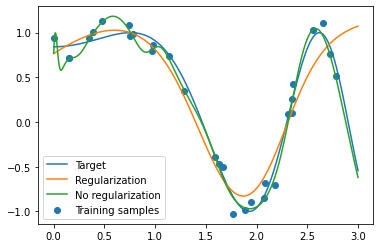

In [21]:
y_pred = big_reg_mdl(x)
y_pred_overfit = big_mdl(x)
plt.scatter(x_train_overfit, y_train_overfit)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.plot(x, y_pred_overfit.numpy())
plt.legend(["Target", "Regularization", "No regularization", "Training samples"])
plt.show()

The model with regularization seems to follow the overall trend of the data, while the model without any regularization very precisely fits the training samples. This is espacilly evident in the interval $\left[0,0.5\right]$, where the prediction of the unregularized model shows an oscillating behavior. Such oscillations are however not present in the ground truth and therefore undesirable. The regularized model on the other hand is not as flexible as the unregularized model and therefore does not fit the target function well in the interval $\left[2.25, 3.0\right]$.

## Conclusion
In this exercise we revisited the mathematical background for a simple regression task and covered it's practical implementation in Tensorflow 2. We also explored the phenomenon of overfitting and derived different regularizations from a probabilistic perspective. This exercise covers a very simple task with a very basic neural architecture and is intended as a primer for the second part of the regression exercise, which is dealing with a bigger and more realistic problem. In this second part we will consider the problem of estimating the age of a person from a potrait picture.